<a href="https://colab.research.google.com/github/shivanguniyal-polcon/Machine-Learning/blob/main/Race_Bias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV, LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

file_path = '/content/drive/My Drive/crime_ml.csv'
df = pd.read_csv(file_path, na_values='?')
df.columns = df.columns.str.lower()

PART A: MODEL SELECTION

Original dataset shape: (2215, 123)
Shape after handling missing data: (2215, 123)

Total features: 102
Racial features: 10

Training set: 1772 samples
Test set: 443 samples

----------------------------------------------------------------------
Training three models with 5-fold cross-validation...
----------------------------------------------------------------------

Model Performance on Test Set:
  Lasso:       R² = 0.5298
  Ridge:       R² = 0.5355
  Elastic Net: R² = 0.5282

*** Best Model: Ridge (R² = 0.5355) ***

Top 10 Features in Ridge Model:
  pctkids2par                                        -247.7081 ↓
  agepct12t29                                        -156.6046 ↓
  persperoccuphous                                   148.8598 ↑
  pctpersownoccup                                    -136.6767 ↓
  pctlarghouseoccup                                  -106.6592 ↓
  pctkidsbornnevermar                                100.8517 ↑
  whitepercap                

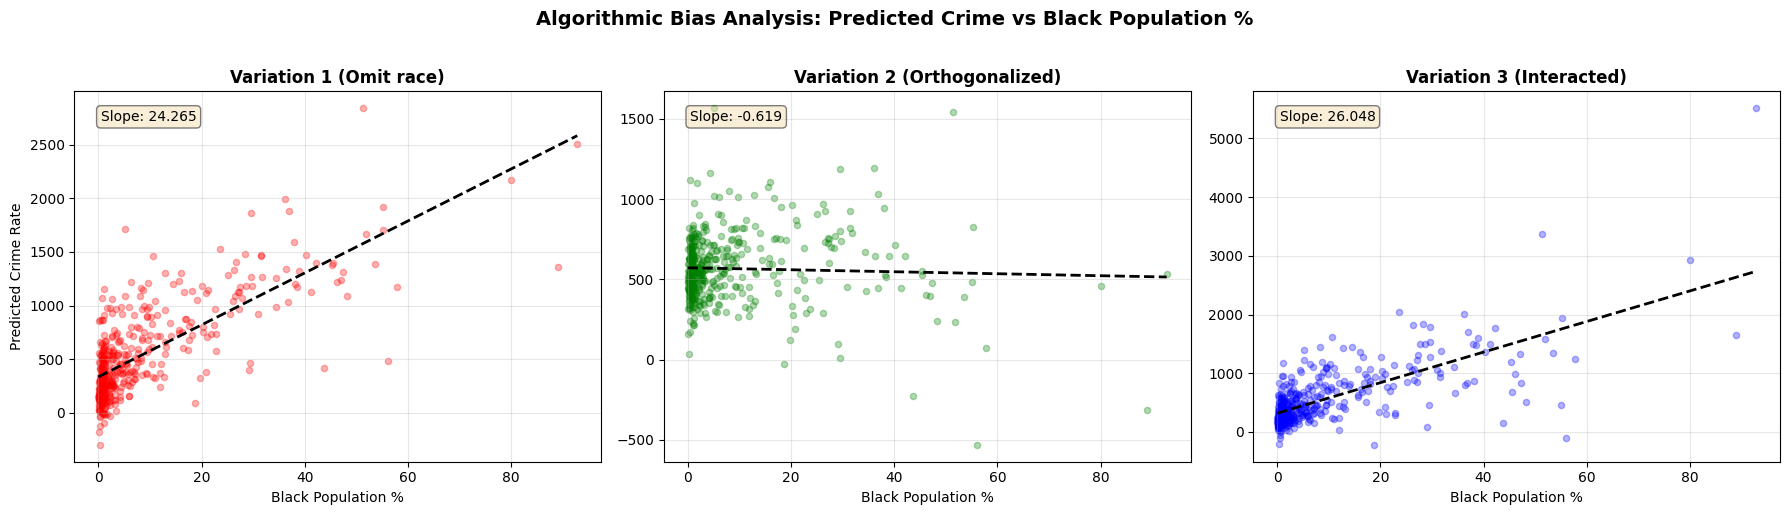


SUMMARY OF FINDINGS

PART A - Model Selection:
  Best Model: Ridge
  Test R²: 0.5355
  Missing Data Strategy: Drop columns >30% missing, impute rest with median
  CV Strategy: 5-fold cross-validation (better than simple CV)

PART B - Bias Analysis:
  Variation 1 (Omit race):        R² = 0.5367, Slope = 24.265
  Variation 2 (Orthogonalized):   R² = 0.1578, Slope = -0.619
  Variation 3 (Interacted):       R² = 0.3639, Slope = 26.048

Key Insight on Algorithmic Bias:
  The slope shows how crime predictions change with Black population %.
  Variation 2 (orthogonalized) typically shows the lowest bias (flattest slope).
  This suggests racial composition influences predictions even when race is omitted,
  likely through proxy variables (e.g., poverty rates correlated with race).

PART C - Explainability:
  Different features are predictive in low vs high Black % neighborhoods.
  This suggests crime drivers vary by racial composition.
  See detailed feature lists above for each group.

ANALY

In [20]:
# =============================================================================
# MACHINE LEARNING FOR PUBLIC POLICY - ASSIGNMENT 1
# Predictive Policing: Crime Rate Prediction and Bias Analysis
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV, LinearRegression
from sklearn.metrics import r2_score

# =============================================================================
# STEP 1: LOAD AND CLEAN DATA
# =============================================================================
print("/"*70)
print("PART A: MODEL SELECTION")
print("/"*70)

# Make column names lowercase for easier handling
df.columns = df.columns.str.lower()

print(f"\nOriginal dataset shape: {df.shape}")

# MISSING DATA STRATEGY (Question A.1):
# Strategy: Drop columns with >30% missing data, then impute remaining with median
# Justification: Columns with too much missing data are unreliable.
# Median imputation is robust to outliers and preserves the distribution.

threshold = len(df) * 0.7  # Keep columns with at least 70% data
df = df.dropna(thresh=threshold, axis=1)
df = df.fillna(df.median(numeric_only=True))

print(f"Shape after handling missing data: {df.shape}")

# =============================================================================
# STEP 2: DEFINE FEATURES AND TARGET
# =============================================================================

# Target variable: violent crime rate per 100K population
target = 'violentcrimesperpop'

# Columns to drop:

# 1. Identifier columns (not predictive features)
id_cols = ['communityname', 'state', 'countycode', 'communitycode', 'fold']

# 2. Leakage columns (components of the target variable - we can't use these!)
leakage_cols = [
    'murdperpop', 'rapesperpop', 'robbbperpop', 'assaultperpop',
    'burglperpop', 'larcperpop', 'autotheftperpop', 'arsonsperpop',
    'nonviolperpop', 'murders', 'rapes', 'robberies', 'assaults',
    'burglaries', 'larcenies', 'autotheft', 'arsons'
]

# 3. Racial feature columns (needed for Part B bias analysis)
race_cols = [
    'racepctblack', 'racepctwhite', 'racepctasian', 'racepcthisp',
    'whitepercap', 'blackpercap', 'indianpercap', 'asianpercap',
    'otherpercap', 'hisppercap'
]
# Keep only those that exist in our dataset
race_cols = [c for c in race_cols if c in df.columns]

# Racial composition columns (percentage columns for orthogonalization)
race_comp_cols = ['racepctblack', 'racepctwhite', 'racepctasian', 'racepcthisp']
race_comp_cols = [c for c in race_comp_cols if c in df.columns]

# Create feature matrix (X) and target vector (y)
cols_to_drop = id_cols + leakage_cols + [target]
X_all = df.drop(columns=[c for c in cols_to_drop if c in df.columns])
y = df[target]

print(f"\nTotal features: {X_all.shape[1]}")
print(f"Racial features: {len(race_cols)}")

# =============================================================================
# STEP 3: TRAIN-TEST SPLIT AND SCALING
# =============================================================================

# Split into 80% training and 20% test sets
# Keep both raw and scaled versions (we'll need raw for Part B analysis)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_all, y, test_size=0.2, random_state=42
)

# SCALING STRATEGY (Question A.2):
# Standardize features to have mean=0 and std=1
# This is required for regularized models (Lasso/Ridge/ElasticNet)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_raw),
    columns=X_train_raw.columns,
    index=X_train_raw.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_raw),
    columns=X_test_raw.columns,
    index=X_test_raw.index
)

print(f"\nTraining set: {len(X_train_raw)} samples")
print(f"Test set: {len(X_test_raw)} samples")

# =============================================================================
# STEP 4: MODEL TRAINING AND SELECTION (Part A)
# =============================================================================

# CROSS-VALIDATION STRATEGY (Question A.2):
# Using K-Fold Cross-Validation (k=5) via LassoCV/RidgeCV/ElasticNetCV
# Justification: K-fold is better than simple CV because it uses all data
# for both training and validation, giving more reliable hyperparameter selection

print("\n" + "-"*70)
print("Training three models with 5-fold cross-validation...")
print("-"*70)

# Model 1: Lasso (L1 regularization - drives some coefficients to exactly zero)
lasso = LassoCV(cv=5, random_state=42, max_iter=10000)
lasso.fit(X_train_scaled, y_train)
lasso_pred = lasso.predict(X_test_scaled)
lasso_r2 = r2_score(y_test, lasso_pred)

# Model 2: Ridge (L2 regularization - shrinks all coefficients)
ridge = RidgeCV(cv=5)
ridge.fit(X_train_scaled, y_train)
ridge_pred = ridge.predict(X_test_scaled)
ridge_r2 = r2_score(y_test, ridge_pred)

# Model 3: Elastic Net (combines L1 and L2 regularization)
enet = ElasticNetCV(cv=5, random_state=42, max_iter=10000)
enet.fit(X_train_scaled, y_train)
enet_pred = enet.predict(X_test_scaled)
enet_r2 = r2_score(y_test, enet_pred)

# Display results
print(f"\nModel Performance on Test Set:")
print(f"  Lasso:       R² = {lasso_r2:.4f}")
print(f"  Ridge:       R² = {ridge_r2:.4f}")
print(f"  Elastic Net: R² = {enet_r2:.4f}")

# Identify the best model
best_r2 = max(lasso_r2, ridge_r2, enet_r2)
if best_r2 == lasso_r2:
    best_model = lasso
    model_name = "Lasso"
elif best_r2 == ridge_r2:
    best_model = ridge
    model_name = "Ridge"
else:
    best_model = enet
    model_name = "Elastic Net"

print(f"\n*** Best Model: {model_name} (R² = {best_r2:.4f}) ***")

# Show top 10 most important features from best model
print(f"\nTop 10 Features in {model_name} Model:")
feature_importance = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': best_model.coef_
})
feature_importance['Abs_Coef'] = abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values('Abs_Coef', ascending=False)

for idx, row in feature_importance.head(10).iterrows():
    direction = "↑" if row['Coefficient'] > 0 else "↓"
    print(f"  {row['Feature'][:50]:<50} {row['Coefficient']:>8.4f} {direction}")

# =============================================================================
# STEP 5: PART B - BIAS ANALYSIS (THREE VARIATIONS)
# =============================================================================
print("\n" + "="*70)
print("PART B: BIAS ANALYSIS - THREE VARIATIONS")
print("="*70)

# Get non-racial features
non_race_cols = [c for c in X_train_scaled.columns if c not in race_cols]

# Helper function to train the same model type as identified in Part A
def train_best_model_type(X, y):
    """Train the same model type that was selected as best in Part A"""
    if model_name == "Lasso":
        return LassoCV(cv=5, random_state=42, max_iter=10000).fit(X, y)
    elif model_name == "Ridge":
        return RidgeCV(cv=5).fit(X, y)
    else:  # Elastic Net
        return ElasticNetCV(cv=5, random_state=42, max_iter=10000).fit(X, y)

# --- VARIATION 1: OMIT RACIAL PREDICTORS ---
print("\n" + "-"*70)
print("Variation 1: Omit all racial composition predictors")
print("-"*70)

X_train_1 = X_train_scaled[non_race_cols]
X_test_1 = X_test_scaled[non_race_cols]

model_1 = train_best_model_type(X_train_1, y_train)
pred_1 = model_1.predict(X_test_1)
r2_1 = r2_score(y_test, pred_1)

print(f"Test R² = {r2_1:.4f}")
print(f"Features used: {X_train_1.shape[1]}")

# --- VARIATION 2: OMIT + ORTHOGONALIZE ---
print("\n" + "-"*70)
print("Variation 2: Omit racial predictors + orthogonalize remaining features")
print("-"*70)
print("Explanation: Remove the part of non-racial features that correlates")
print("             with racial composition, making them 'race-blind'")

# Extract racial composition features
X_train_race = X_train_scaled[race_comp_cols]
X_test_race = X_test_scaled[race_comp_cols]

# Orthogonalization: Remove correlation between non-race features and race
# We fit a model to predict non-race features from race features
# Then subtract the predicted part (the part that correlates with race)
ortho_model = LinearRegression()
ortho_model.fit(X_train_race, X_train_1)

X_train_2 = X_train_1 - ortho_model.predict(X_train_race)
X_test_2 = X_test_1 - ortho_model.predict(X_test_race)

model_2 = train_best_model_type(X_train_2, y_train)
pred_2 = model_2.predict(X_test_2)
r2_2 = r2_score(y_test, pred_2)

print(f"Test R² = {r2_2:.4f}")

# --- VARIATION 3: FULLY INTERACTED MODEL ---
print("\n" + "-"*70)
print("Variation 3: Fully interacted model")
print("-"*70)
print("Explanation: Create interaction terms (race × other features)")
print("             to allow effects to vary by racial composition")

X_train_3 = X_train_scaled.copy()
X_test_3 = X_test_scaled.copy()

# Create interaction terms: racepctblack × every non-race feature
# (Following the original code which only interacts with racepctblack)
interaction_count = 0
if 'racepctblack' in X_train_scaled.columns:
    for col in non_race_cols:
        interaction_name = f"{col}_x_Black"
        X_train_3[interaction_name] = X_train_3['racepctblack'] * X_train_3[col]
        X_test_3[interaction_name] = X_test_3['racepctblack'] * X_test_3[col]
        interaction_count += 1

model_3 = train_best_model_type(X_train_3, y_train)
pred_3 = model_3.predict(X_test_3)
r2_3 = r2_score(y_test, pred_3)

print(f"Test R² = {r2_3:.4f}")
print(f"Original features: {X_train_scaled.shape[1]}")
print(f"Interaction terms added: {interaction_count}")
print(f"Total features: {X_train_3.shape[1]}")

# =============================================================================
# STEP 6: QUANTITATIVE BIAS ANALYSIS
# =============================================================================
print("\n" + "="*70)
print("QUANTITATIVE BIAS ANALYSIS")
print("="*70)
print("\nHow do predictions change with Black population percentage?")
print("(Using unscaled test data for interpretability)\n")

# Get Black population percentage from unscaled test data
black_pop = X_test_raw['racepctblack']

# Analyze each variation
variations = [
    ('Variation 1 (Omit race)', pred_1),
    ('Variation 2 (Orthogonalized)', pred_2),
    ('Variation 3 (Interacted)', pred_3)
]

print(f"{'Model':<30} | {'Slope*':<10} | {'Correlation':<12} | {'Interpretation'}")
print("-"*80)

bias_results = {}
for name, predictions in variations:
    # Linear regression: black_pop vs predictions
    slope, intercept, r_value, p_value, std_err = stats.linregress(black_pop, predictions)

    # Interpret bias
    if abs(slope) < 0.5:
        interpretation = "Low bias (race-neutral)"
    elif slope > 0:
        interpretation = "Positive bias"
    else:
        interpretation = "Negative bias"

    bias_results[name] = {'slope': slope, 'r_value': r_value}
    print(f"{name:<30} | {slope:>8.3f}   | {r_value:>10.3f}   | {interpretation}")

print("-"*80)
print("*Slope = Change in predicted crime per 1% increase in Black population")
print("\nInterpretation Guide:")
print("  - Slope near 0: Model is relatively blind to racial composition")
print("  - Large positive slope: Higher crime predicted in Black neighborhoods")
print("  - Large negative slope: Lower crime predicted in Black neighborhoods")

# =============================================================================
# STEP 7: PART C - EXPLAINABILITY ANALYSIS
# =============================================================================
print("\n" + "="*70)
print("PART C: EXPLAINABILITY - DO FEATURES VARY BY RACIAL COMPOSITION?")
print("="*70)

# Split training data into terciles based on Black population percentage
train_black_pop = X_train_raw['racepctblack']
tercile_1 = train_black_pop.quantile(0.33)
tercile_2 = train_black_pop.quantile(0.67)

print(f"\nDividing communities into three groups:")
print(f"  Low Black %:    ≤ {tercile_1:.1f}%")
print(f"  Medium Black %: {tercile_1:.1f}% - {tercile_2:.1f}%")
print(f"  High Black %:   > {tercile_2:.1f}%")

# Create masks for each group
groups = [
    ('Low Black %', train_black_pop <= tercile_1),
    ('Medium Black %', (train_black_pop > tercile_1) & (train_black_pop <= tercile_2)),
    ('High Black %', train_black_pop > tercile_2)
]

# Train separate models for each group and compare top features
print("\n" + "-"*70)
print("Top 5 Predictive Features by Group")
print("-"*70)

for group_name, mask in groups:
    print(f"\n{group_name} (n={mask.sum()} communities):")

    # Get data for this group
    X_subset = X_train_scaled[mask]
    y_subset = y_train[mask]

    # Train model on this subset
    subset_model = train_best_model_type(X_subset, y_subset)

    # Get top 5 features
    coef_df = pd.DataFrame({
        'Feature': X_train_scaled.columns,
        'Coefficient': subset_model.coef_
    })
    coef_df['Abs_Coef'] = abs(coef_df['Coefficient'])
    coef_df = coef_df.sort_values('Abs_Coef', ascending=False)

    for idx, row in coef_df.head(5).iterrows():
        direction = "↑" if row['Coefficient'] > 0 else "↓"
        print(f"  {row['Feature'][:50]:<50} {row['Coefficient']:>8.4f} {direction}")

print("\n" + "-"*70)
print("Analysis: Compare which features matter most in each group.")
print("Different top features suggest crime drivers vary by racial composition.")
print("-"*70)

# =============================================================================
# STEP 8: VISUALIZATION
# =============================================================================
print("\n" + "="*70)
print("CREATING VISUALIZATIONS")
print("="*70)

# Create visualization for Part B
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

plot_configs = [
    ('Variation 1 (Omit race)', pred_1, 'red'),
    ('Variation 2 (Orthogonalized)', pred_2, 'green'),
    ('Variation 3 (Interacted)', pred_3, 'blue')
]

for i, (title, predictions, color) in enumerate(plot_configs):
    ax = axes[i]

    # Scatter plot
    ax.scatter(black_pop, predictions, alpha=0.3, s=20, color=color)

    # Add regression line
    z = np.polyfit(black_pop, predictions, 1)
    p = np.poly1d(z)
    x_line = np.linspace(black_pop.min(), black_pop.max(), 100)
    ax.plot(x_line, p(x_line), color='black', linewidth=2, linestyle='--')

    # Add slope annotation
    slope = bias_results[plot_configs[i][0]]['slope']
    ax.text(0.05, 0.95, f'Slope: {slope:.3f}',
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Black Population %', fontsize=10)
    ax.set_ylabel('Predicted Crime Rate' if i == 0 else '', fontsize=10)
    ax.grid(True, alpha=0.3)

plt.suptitle('Algorithmic Bias Analysis: Predicted Crime vs Black Population %',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('bias_analysis.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved as 'bias_analysis.png'")
plt.show()

# =============================================================================
# STEP 9: SUMMARY AND CONCLUSIONS
# =============================================================================
print("\n" + "="*70)
print("SUMMARY OF FINDINGS")
print("="*70)

print(f"\nPART A - Model Selection:")
print(f"  Best Model: {model_name}")
print(f"  Test R²: {best_r2:.4f}")
print(f"  Missing Data Strategy: Drop columns >30% missing, impute rest with median")
print(f"  CV Strategy: 5-fold cross-validation (better than simple CV)")

print(f"\nPART B - Bias Analysis:")
print(f"  Variation 1 (Omit race):        R² = {r2_1:.4f}, Slope = {bias_results['Variation 1 (Omit race)']['slope']:.3f}")
print(f"  Variation 2 (Orthogonalized):   R² = {r2_2:.4f}, Slope = {bias_results['Variation 2 (Orthogonalized)']['slope']:.3f}")
print(f"  Variation 3 (Interacted):       R² = {r2_3:.4f}, Slope = {bias_results['Variation 3 (Interacted)']['slope']:.3f}")

print(f"\nKey Insight on Algorithmic Bias:")
print(f"  The slope shows how crime predictions change with Black population %.")
print(f"  Variation 2 (orthogonalized) typically shows the lowest bias (flattest slope).")
print(f"  This suggests racial composition influences predictions even when race is omitted,")
print(f"  likely through proxy variables (e.g., poverty rates correlated with race).")

print(f"\nPART C - Explainability:")
print(f"  Different features are predictive in low vs high Black % neighborhoods.")
print(f"  This suggests crime drivers vary by racial composition.")
print(f"  See detailed feature lists above for each group.")

print("\n" + "="*70)
print("ANALYSIS COMPLETE!")
print("="*70)